In [1]:
!pip install -q torchvision

import os, shutil
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.1 MB/s eta 0:00:00


In [2]:
# Define the transformation pipeline for input images
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize input image to 224x224 (expected by ResNet)
    transforms.ToTensor()          # Convert image to PyTorch tensor
])

# Define a custom feature extractor class using ResNet-50
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        super(resnet_feature_extractor, self).__init__()

        # Load pretrained ResNet-50 model with default weights
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()  # Set model to evaluation mode (disable dropout, batchnorm updates)

        # Freeze all model parameters (no gradient updates)
        for param in self.model.parameters():
            param.requires_grad = False

        # Define a forward hook to capture feature maps from intermediate layers
        def hook(module, input, output):
            self.features.append(output)

        # Register hooks on the last block of layer2 and layer3
        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, x):
        self.features = []  # Clear any previously stored features

        # Forward pass without gradient computation
        with torch.no_grad():
            _ = self.model(x)  # Run input through the full ResNet model

        # Apply 2D average pooling to smooth feature maps
        self.avg = torch.nn.AvgPool2d(kernel_size=3, stride=1)

        # Determine the spatial size of the first captured feature map
        fmap_size = self.features[0].shape[-2]

        # Resize all feature maps to have the same spatial size using adaptive pooling
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        # Apply pooling and resizing to all captured feature maps
        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]

        # Concatenate feature maps along the channel dimension
        patch = torch.cat(resized_maps, dim=1)  # shape: (B, C_total, H, W)

        # Flatten each spatial location's concatenated features to form a patch matrix
        patch = patch.reshape(patch.shape[1], -1).T  # shape: (H*W, C_total)

        return patch  # Return patch matrix of shape (num_patches, total_channels)


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Initialize an empty list to store extracted features (memory bank)
memory_bank = []

# Instantiate the ResNet-based feature extractor and move it to GPU
backbone = resnet_feature_extractor().cuda()

# Define the path to the training "good" images in the MVTec zipper dataset
folder_path = Path('/content/drive/MyDrive/mvtec_anomaly_detection/metal_nut/train/good')

# Iterate over all image files in the folder
for pth in tqdm(folder_path.iterdir(), leave=False):
    # Load the image, convert to RGB (ensure no alpha channel), apply transforms
    with torch.no_grad():  # Disable gradient computation for faster inference
        data = transform(Image.open(pth).convert("RGB")).cuda().unsqueeze(0)  # Shape: (1, 3, 224, 224)

        # Extract features using the backbone
        features = backbone(data)  # Shape: (num_patches, feature_dim) e.g., (784, 391)

        # Store features in CPU memory to save GPU memory
        memory_bank.append(features.cpu().detach())

# Print how many images were processed
print(len(memory_bank))  # Should equal number of images in the folder

# Print the shape of the feature map for the first image
print(memory_bank[0].shape)  # e.g., torch.Size([784, 391])

# Concatenate all feature maps along the patch dimension
memory_bank = torch.cat(memory_bank, dim=0).cuda()  # Shape: (total_patches_across_all_images, feature_dim)

# Output the final memory bank shape
memory_bank.shape  # e.g., torch.Size([306544, 391]) = 784 patches × num_images, each of 391 features


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


0it [00:00, ?it/s]

220
torch.Size([784, 1536])


torch.Size([172480, 1536])

In [5]:
# Randomly select 10% of the feature vectors from the memory bank without replacement
selected_indices = np.random.choice(len(memory_bank), size=len(memory_bank)//10, replace=False)

# Subsample the memory bank using the selected indices
memory_bank = memory_bank[selected_indices]

# Output the new shape of the memory bank (should be 10% of the original size)
memory_bank.shape


torch.Size([17248, 1536])

In [6]:
# Initialize a list to store the anomaly scores (y_score_good) for all "good" training images
y_score_good = []

# Define the folder path again to iterate over all "good" images from the training set
folder_path = Path('/content/drive/MyDrive/mvtec_anomaly_detection/metal_nut/train/good')

# Iterate through each image file in the folder
for pth in tqdm(folder_path.iterdir(), leave=False):
    # Load and preprocess the image: resize, normalize, and add batch dimension
    data = transform(Image.open(pth).convert("RGB")).cuda().unsqueeze(0)  # Shape: (1, 3, 224, 224)

    with torch.no_grad():  # Disable gradient tracking for inference
        features = backbone(data)  # Extract patch features → shape: (784, 391)

    # Compute pairwise Euclidean distances between extracted features and memory bank
    distances = torch.cdist(features, memory_bank, p=2.0)  # Shape: (784, memory_bank_size)

    # For each patch in the image, find the minimum distance to the memory bank
    dist_score, dist_score_idxs = torch.min(distances, dim=1)  # dist_score: (784,)

    # Use the maximum of all minimum distances as the anomaly score for the image
    s_star = torch.max(dist_score)  # Higher score → more anomalous

    # Optionally reshape per-patch distance scores into a 28x28 segmentation map
    segm_map = dist_score.view(1, 1, 28, 28)  # Useful for pixel-level anomaly visualization

    # Store the image-level anomaly score
    y_score_good.append(s_star.cpu().numpy())
    # break  # Uncomment for debugging a single iteration

# Preview the first 5 image-level anomaly scores
y_score_good[:5]


0it [00:00, ?it/s]

[array(13.765262, dtype=float32),
 array(12.175159, dtype=float32),
 array(14.22541, dtype=float32),
 array(12.460357, dtype=float32),
 array(14.071746, dtype=float32)]

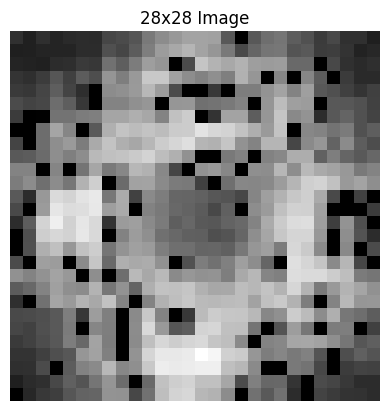

In [7]:
# Preview the first 5 image-level anomaly scores for "good" training images
y_score_good[:5]

# Remove batch and channel dimensions from the segmentation map
# Original shape: (1, 1, 28, 28) → After squeeze: (28, 28)
image_np = segm_map.squeeze().cpu()

# Plot the 28x28 anomaly score heatmap (distance map)
plt.imshow(image_np, cmap='gray')  # Use grayscale colormap
plt.title("28x28 Image")           # Title of the plot
plt.axis("off")                    # Hide x and y axis for cleaner view
plt.show()


13.309807
0.73102367
Threshold: 15.502878189086914


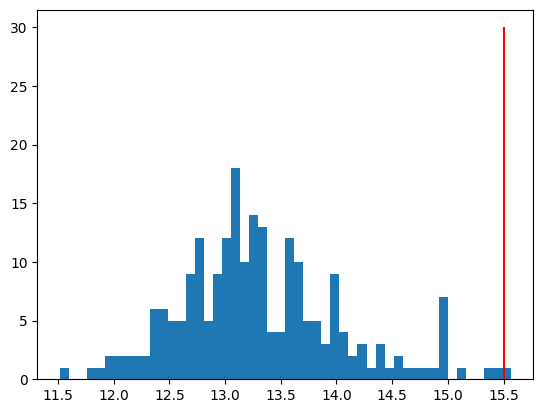

In [8]:
# Calculate the mean anomaly score of all "good" training images
print(np.mean(y_score_good))  # Expected to be relatively low

# Calculate the standard deviation of anomaly scores
print(np.std(y_score_good))   # Indicates spread/variance in anomaly scores

# Define the anomaly detection threshold as μ + 3σ (3-sigma rule)
# Assumes "good" scores follow a roughly Gaussian distribution
best_threshold = np.mean(y_score_good) + 3 * np.std(y_score_good)
print(f"Threshold: {best_threshold}")

# Plot histogram of anomaly scores for "good" images
plt.hist(y_score_good, bins=50)

# Draw a vertical red line at the computed threshold
plt.vlines(x=best_threshold, ymin=0, ymax=30, color='r')

# Show the plot
plt.show()


In [9]:
# Lists to store predicted anomaly scores and ground truth labels
y_score = []  # Image-level anomaly scores
y_true = []   # Corresponding ground truth labels (0 = good, 1 = defect)

# Path to test dataset root folder
base_test_path = Path("/content/drive/MyDrive/mvtec_anomaly_detection/metal_nut/test")

# Iterate over all defect types (including 'good')
for defect_type in ['bent', 'color', 'flip', 'good', 'scratch']:

    folder_path_test = base_test_path / defect_type  # Path to current subfolder

    for pth in tqdm(folder_path_test.iterdir(), leave=False):
        class_label = pth.parts[-2]  # Get defect category from path (e.g., 'good', 'rough', etc.)

        with torch.no_grad():  # Disable gradient computation
            # Load and preprocess image
            test_image = transform(Image.open(pth).convert("RGB")).cuda().unsqueeze(0)

            # Extract features using the backbone model
            features = backbone(test_image)  # Shape: (784, 391)

        # Compute L2 distance between extracted features and memory bank
        distances = torch.cdist(features, memory_bank, p=2.0)

        # For each patch, find the minimum distance to memory bank
        dist_score, _ = torch.min(distances, dim=1)

        # Maximum patch distance is the image-level anomaly score
        s_star = torch.max(dist_score)

        # Optional: create 28x28 segmentation map from patch distances (useful for heatmap visualization)
        segm_map = dist_score.view(1, 1, 28, 28)

        # Append results
        y_score.append(s_star.cpu().numpy())
        y_true.append(0 if class_label == 'good' else 1)  # 0 = normal, 1 = anomaly


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
y_score[40:45], y_true[40:45]

([array(23.366669, dtype=float32),
  array(20.992207, dtype=float32),
  array(14.004607, dtype=float32),
  array(18.815985, dtype=float32),
  array(17.973526, dtype=float32)],
 [1, 1, 1, 1, 1])

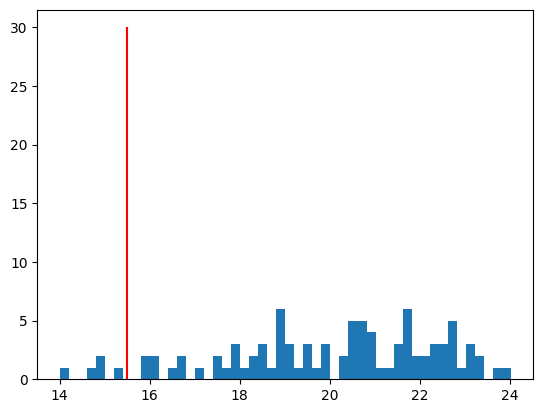

In [11]:
# Filter out anomaly scores (y_score) that correspond to the 'BAD' (defective) class
y_score_bad = [score for score, true in zip(y_score, y_true) if true == 1]

# Plot a histogram of anomaly scores for BAD samples
plt.hist(y_score_bad, bins=50)

# Draw a vertical red line at the threshold (computed earlier using 3-sigma rule)
plt.vlines(x=best_threshold, ymin=0, ymax=30, color='r')

# Display the plot
plt.show()


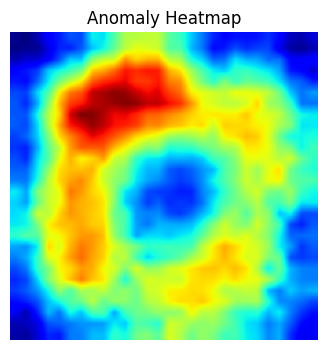

In [12]:
# Path to a specific defective test image
test_image_path = '/content/drive/MyDrive/mvtec_anomaly_detection/metal_nut/test/scratch/000.png'

# Extract features from the input image using the pretrained backbone
features = backbone(test_image)  # test_image must be defined before this line

# Compute pairwise Euclidean distances between patches and memory bank
distances = torch.cdist(features, memory_bank, p=2.0)

# For each patch, find the closest (minimum distance) memory bank feature
dist_score, dist_score_idxs = torch.min(distances, dim=1)

# Use the maximum patch-level distance as the image-level anomaly score
s_star = torch.max(dist_score)

# Reshape per-patch distances into a 28x28 segmentation map
segm_map = dist_score.view(1, 1, 28, 28)

# Upscale the segmentation map to 224x224 to match the original image resolution
# This makes it visually align with the input image if you overlay it
segm_map = torch.nn.functional.interpolate(
                segm_map,
                size=(224, 224),
                mode='bilinear'
            )

# Plot the upscaled anomaly heatmap using 'jet' colormap for better visual contrast
plt.figure(figsize=(4, 4))
plt.imshow(segm_map.cpu().squeeze(), cmap='jet')
plt.title("Anomaly Heatmap")
plt.axis("off")
plt.show()


AUC-ROC Score: 0.9853372434017595
fpr, tpr, thresholds:  [0.         0.         0.         0.04545455 0.04545455 0.09090909
 0.09090909 0.18181818 0.18181818 0.54545455 0.54545455 1.        ] [0.         0.01075269 0.90322581 0.90322581 0.94623656 0.94623656
 0.95698925 0.95698925 0.98924731 0.98924731 1.         1.        ] [      inf 24.018429 16.53213  16.262608 15.935739 15.428661 15.296883
 14.918959 14.770254 14.188081 14.004607 12.644429]
f1_scores: [0.0, 0.02127659574468085, 0.9491525423728814, 0.9438202247191011, 0.967032967032967, 0.9617486338797814, 0.967391304347826, 0.956989247311828, 0.9735449735449735, 0.934010152284264, 0.9393939393939394, 0.8942307692307693]
best_threshold = 14.770254135131836


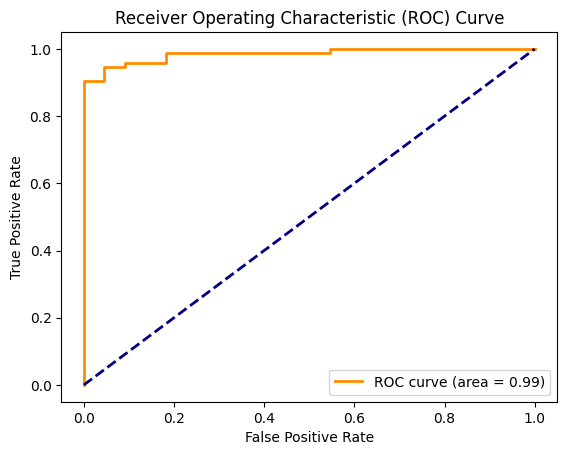

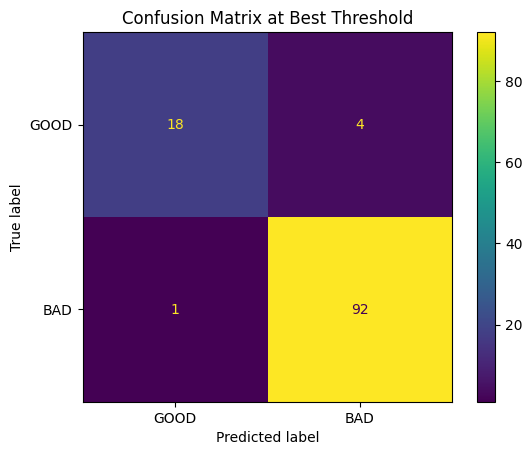

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score

# ----------------------------
# Step 1: Compute AUC-ROC score
# ----------------------------
# Measures the model's ability to distinguish between GOOD (0) and BAD (1) images
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# ----------------------------
# Step 2: Generate ROC curve
# ----------------------------
# Returns False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_score)
print("fpr, tpr, thresholds: ", fpr, tpr, thresholds)

# ----------------------------
# Step 3: Calculate F1 score for each threshold
# ----------------------------
# Evaluate which threshold gives the best balance of precision and recall
f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]
print("f1_scores:", f1_scores)

# Select threshold that yields the highest F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'best_threshold = {best_threshold}')

# ----------------------------
# Step 4: Plot ROC curve
# ----------------------------
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line = random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ----------------------------
# Step 5: Display Confusion Matrix
# ----------------------------
# Use the best threshold to classify predictions
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GOOD', 'BAD'])
disp.plot()
plt.title("Confusion Matrix at Best Threshold")
plt.show()


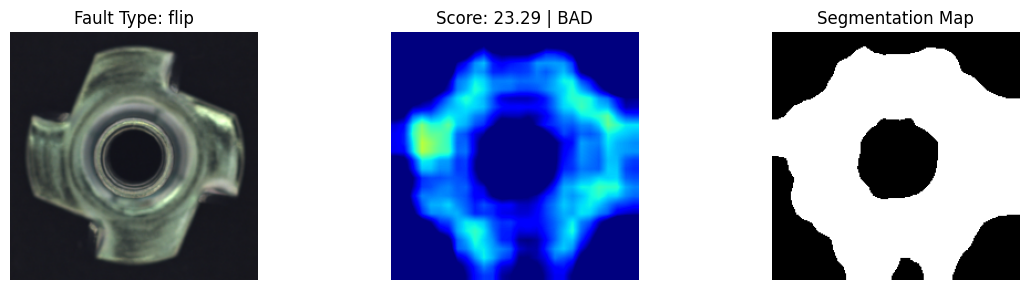

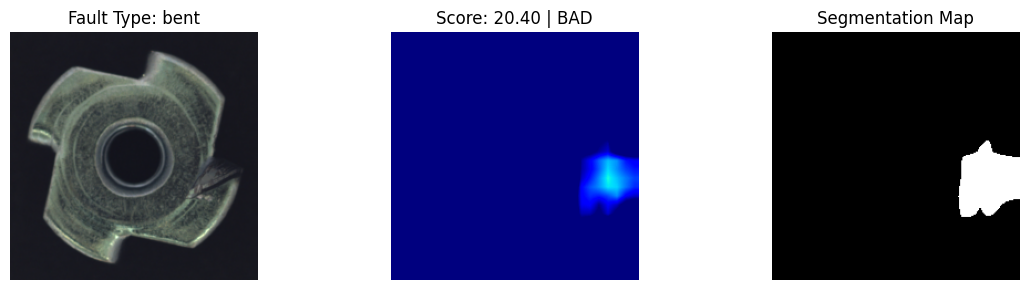

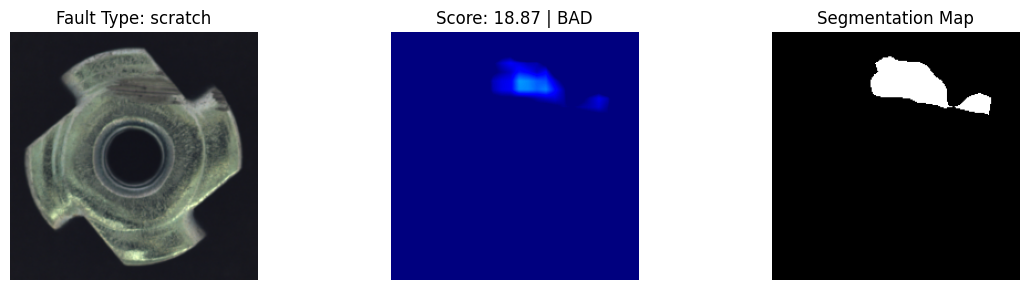

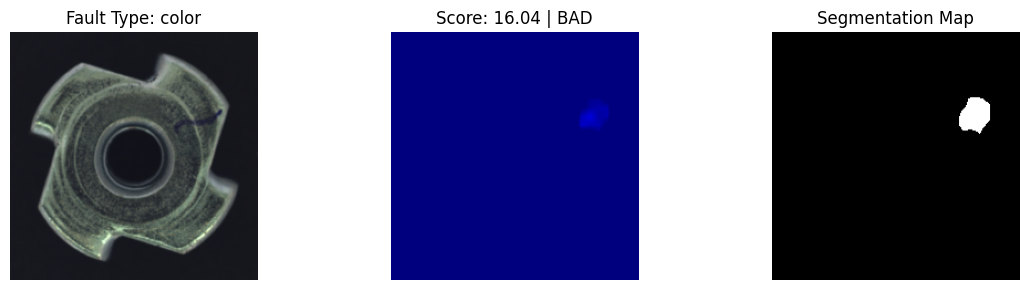

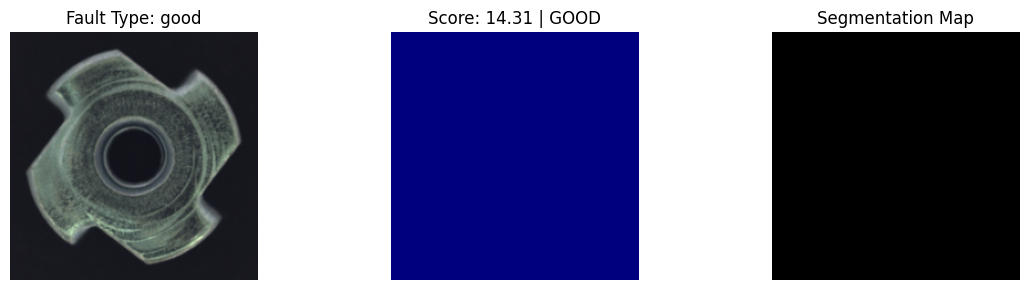

In [18]:
import os
import cv2
import time
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

backbone.eval()
class_label   = ['GOOD', 'BAD']
wanted_types  = {'bent', 'color', 'flip', 'good', 'scratch'}

test_path     = Path('/content/drive/MyDrive/mvtec_anomaly_detection/metal_nut/test')
output_root   = Path('/content/outputs')

# Track which fault types have already been displayed
displayed_faults = set()

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    item_name  = path.parts[-4]

    if fault_type not in wanted_types:
        continue

    # Load and transform the image
    test_image = transform(Image.open(path).convert("RGB")).cuda().unsqueeze(0)

    with torch.no_grad():
        features = backbone(test_image)

    distances     = torch.cdist(features, memory_bank, p=2.0)
    dist_score, _ = torch.min(distances, dim=1)
    s_star        = torch.max(dist_score)

    segm_map = dist_score.view(1, 1, 28, 28)
    segm_map = torch.nn.functional.interpolate(
        segm_map, size=(224, 224), mode='bilinear'
    ).cpu().squeeze().numpy()

    y_score_image = s_star.cpu().numpy()
    y_pred_image  = 1 * (y_score_image >= best_threshold)

    # Create output path
    save_path = output_root / item_name / 'test' / fault_type
    save_path.mkdir(parents=True, exist_ok=True)

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    axs[0].imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[0].set_title(f'Fault Type: {fault_type}')
    axs[0].axis('off')

    axs[1].imshow(segm_map, cmap='jet', vmin=best_threshold, vmax=best_threshold * 2)
    axs[1].set_title(f'Score: {y_score_image:.2f} | {class_label[y_pred_image]}')
    axs[1].axis('off')

    axs[2].imshow((segm_map > best_threshold), cmap='gray')
    axs[2].set_title('Segmentation Map')
    axs[2].axis('off')

    plt.tight_layout()

    # Save visualization
    out_file = save_path / f'{path.stem}_vis.png'
    fig.savefig(out_file)

    # Display only the first image per fault type
    if fault_type not in displayed_faults:
        plt.show()
        displayed_faults.add(fault_type)
    else:
        plt.close(fig)


In [15]:
import shutil
from google.colab import files

shutil.make_archive('/content/outputs', 'zip', '/content/outputs')
files.download('/content/outputs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>